<a href="https://colab.research.google.com/github/BijanKangani/IUST_Study/blob/main/STL10_CNN_pytorch_HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
from torchvision import datasets, transforms
from torch import nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Subset
import random


# Load STL10 Dataset

In [3]:
# Device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("device:", device)

# Transform (output: 64x64)
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(64, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

val_transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

# download STL10 dataset
root = "./data"
base_full = datasets.STL10(root=root, split='train', download=True)

# Devidding the train/validation (80/20)
seed = 42
g = torch.Generator().manual_seed(seed)
n_total = len(base_full)
indices = torch.randperm(n_total, generator=g).tolist()

val_ratio = 0.2
n_val = int(n_total * val_ratio)
n_train = n_total - n_val
train_idx = indices[:n_train]
val_idx   = indices[n_train:]


full_train = datasets.STL10(root=root, split='train', download=False, transform=train_transform)
full_val   = datasets.STL10(root=root, split='train', download=False, transform=val_transform)

training_dataset = Subset(full_train, train_idx)
validation_dataset = Subset(full_val, val_idx)

batch_size = 64
training_loader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True,  num_workers=2, pin_memory=(device.type=='cuda'))
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=(device.type=='cuda'))

print("train size:", len(training_dataset))
print("val size:", len(validation_dataset))
print("len(training_loader):", len(training_loader))
print("len(validation_loader):", len(validation_loader))


device: cpu


100%|██████████| 2.64G/2.64G [00:56<00:00, 46.6MB/s]


train size: 4000
val size: 1000
len(training_loader): 63
len(validation_loader): 16


# Load Different Layers and Create the Model

In [4]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 64 -> 32

            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 32 -> 16

            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 16 -> 8

            nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(inplace=True),

            nn.AdaptiveAvgPool2d((1, 1))     # (B,256,1,1)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


# Compiling the Model

In [5]:
net = SimpleCNN(num_classes=10).to(device)
net


SimpleCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, af

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(net.parameters(), lr=3e-4, weight_decay=1e-4)


# Train the model

In [7]:
epochs = 50

running_loss_history = []
running_correct_history = []
val_running_loss_history = []
val_running_correct_history = []

# Early Stopping settings
patience = 8
min_delta = 1e-4
best_val_loss = float("inf")
best_epoch = -1
pat_cnt = 0

for e in range(epochs):
    # --------- train ----------
    net.train()
    train_loss_sum = 0.0
    train_correct = 0
    train_total = 0

    for inputs, labels in training_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = net(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss_sum += loss.item() * inputs.size(0)  # جمع loss روی نمونه‌ها
        preds = torch.argmax(outputs, dim=1)
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)

    epoch_loss = train_loss_sum / train_total
    acc = train_correct / train_total

    # --------- validation ----------
    net.eval()
    val_loss_sum = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for val_inputs, val_labels in validation_loader:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            val_outputs = net(val_inputs)
            val_loss = criterion(val_outputs, val_labels)

            val_loss_sum += val_loss.item() * val_inputs.size(0)
            val_preds = torch.argmax(val_outputs, dim=1)
            val_correct += (val_preds == val_labels).sum().item()
            val_total += val_labels.size(0)

    val_epoch_loss = val_loss_sum / val_total
    val_acc = val_correct / val_total

    # store history
    running_loss_history.append(epoch_loss)
    running_correct_history.append(acc)
    val_running_loss_history.append(val_epoch_loss)
    val_running_correct_history.append(val_acc)

    print(f"Epoch {e+1:02d} | training loss: {epoch_loss:.4f} training accuracy: {acc*100:.2f}%")
    print(f"            | val loss     : {val_epoch_loss:.4f} val accuracy     : {val_acc*100:.2f}%")

    # Early stopping check
    if val_epoch_loss < best_val_loss - min_delta:
        best_val_loss = val_epoch_loss
        best_epoch = e + 1
        pat_cnt = 0
        torch.save(net.state_dict(), "best_stl10_cnn.pt")
    else:
        pat_cnt += 1
        if pat_cnt >= patience:
            print("\nEarly stopping activated.")
            break

#best weight
net.load_state_dict(torch.load("best_stl10_cnn.pt", map_location=device))

print("\nBest epoch:", best_epoch, "| best val_loss:", best_val_loss)


Epoch 01 | training loss: 1.8281 training accuracy: 31.60%
            | val loss     : 1.5973 val accuracy     : 41.20%
Epoch 02 | training loss: 1.5950 training accuracy: 40.62%
            | val loss     : 1.5667 val accuracy     : 41.10%
Epoch 03 | training loss: 1.4871 training accuracy: 45.77%
            | val loss     : 1.4718 val accuracy     : 42.40%
Epoch 04 | training loss: 1.4026 training accuracy: 49.23%
            | val loss     : 1.5403 val accuracy     : 40.60%
Epoch 05 | training loss: 1.3401 training accuracy: 52.25%
            | val loss     : 1.3533 val accuracy     : 50.30%
Epoch 06 | training loss: 1.3031 training accuracy: 52.28%
            | val loss     : 1.5939 val accuracy     : 39.00%
Epoch 07 | training loss: 1.2668 training accuracy: 53.92%
            | val loss     : 1.2827 val accuracy     : 50.90%
Epoch 08 | training loss: 1.2166 training accuracy: 55.50%
            | val loss     : 1.2663 val accuracy     : 53.00%
Epoch 09 | training loss: 1.1870

# Plot Learning Curve

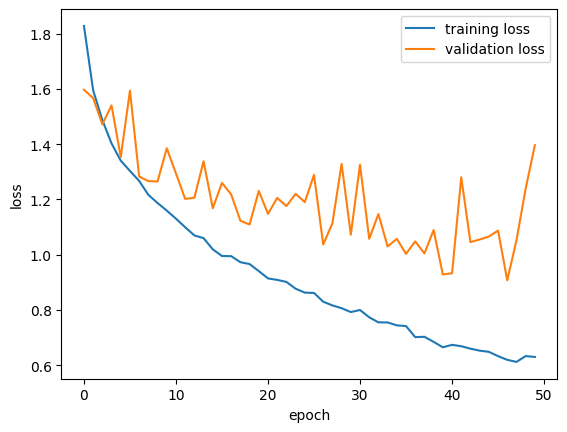

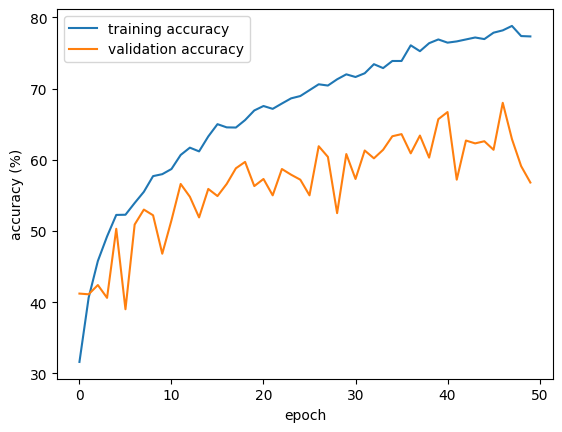

Best epoch (stop here): 47
Validation accuracy at best epoch: 68.0 %


In [9]:
plt.figure()
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

plt.figure()
plt.plot([a*100 for a in running_correct_history], label='training accuracy')
plt.plot([a*100 for a in val_running_correct_history], label='validation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy (%)')
plt.legend()
plt.show()

print("Best epoch (stop here):", best_epoch)
print("Validation accuracy at best epoch:", val_running_correct_history[best_epoch-1]*100, "%")
